Developing the code to calculate helix/helix angle.




In [1]:
import sys

import MDAnalysis as mda
from MDAnalysis.analysis import dihedrals
from MDAnalysis.analysis import contacts
from statistics import mean, stdev
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import time
import glob
import math

sys.path.append('/home/khlee/repositories/pia-x/coupler/scripts')
from _heatmap import *



In [2]:
def get_angle(u, v):
    """
    Description:
        angle calculation module. angles are given in radians. return a dictionary with frame number as the key.
    Arguments:
        vectors a and b
        frame id
    """
    u = np.squeeze(np.asarray(u))
    v = np.squeeze(np.asarray(v))

    cosa = np.dot(u, v) / np.linalg.norm(u) / np.linalg.norm(v)  # -> cosine of the angle
    angle = np.arccos(np.clip(cosa, -1, 1))
    return angle


def helix_orientation(u, segid, resid, sigma_cutoff=1.5):
    # ADAPTED AND MODIFIED FROM:
    #     anglebetweenhelices.py
    #     helix_angle_calc.py

    ind1 = u.select_atoms('protein and segid C'+segid+' and resid '+resid+' and name C')
    ind2 = u.select_atoms('protein and segid C'+segid+' and resid '+resid+' and name O')

    vecs = np.array([])
    n=0
    for ts in u.trajectory:
        c1 = ind1.positions
        c2 = ind2.positions
        vec_list = c2 - c1
        vec = np.sum(vec_list, axis=0)

        angle_list = [get_angle(vec, x) for x in vec_list]
        # calculate the angle between the average vec and each of the individual vec in the vec_list.
        angle_mu = np.mean(angle_list)
        angle_std = np.std(angle_list)
        # '''
        # compare each of the above calculated angle with angle_std * sigma_cutoff. if the angle value is greater than angle_std * sigma_cutoff,
        # exclude the outlier vector from the vec_list.
        # '''
        nvec_list = [vec_list[i] for i in range(len(vec_list)) if abs(angle_list[i] - angle_mu) < angle_std * sigma_cutoff]
        vec = np.sum(nvec_list, axis=0)  # create an average vector for the helical segment after removing outliers
        # print "vec_list2 :\n", vec_list
        # print "vector2 :", vec
        vec = vec / np.linalg.norm(vec)
#         print(vec)
#         print(n)
    return vec


def convert_angle(angle):
    """
    Description:
        module to convert radians to degrees.
    Arguments:
        vectors a and b
        frame id
    """
    angle_deg = math.degrees(float(angle))

    if angle_deg < 0:
        angle_deg += 360
        return angle_deg
    else:
        return angle_deg


In [3]:
# testcase
PDB="infiles/d3_gi_pd_mod.pdb"
DCDs=glob.glob('infiles/test_d3_gi_pd_*.dcd')
u = mda.Universe(PDB, DCDs)

## psf / dcds  ==> N+1 frames
## pdb / dcds  ==> N frames

In [4]:
# define
# receptor
rec_chainid='R'
rec_segments=['27:57', '63:91', '100:134', '145:170', '186:218', '322:354', '362:400']
rec_labels=['TM1','TM2','TM3','TM4','TM5','TM6','TM7']
# Ga
ga_chainid='A'
ga_segments=['7:31','47:56','242:255','271:280', '296:311','329:351']
# need to refine above definition

# steal from https://www.uniprot.org/uniprot/P63096


In [5]:
# create matrix


def get_segments_angle(segmanet_list1, segmanet_chainid1, segmanet_list2, segmanet_chainid2):
    # get segments angles
    
    matrix = np.zeros((len(segmanet_list1), len(segmanet_list2)))

    if str(segmanet_chainid1)==str(segmanet_chainid2):
        for i in range(len(segmanet_list1)):
            for j in range(i+1,len(segmanet_list2)):
                _vi=helix_orientation(u, segmanet_chainid1, segmanet_list1[i], sigma_cutoff=1.5)
                _vj=helix_orientation(u, segmanet_chainid2, segmanet_list2[j], sigma_cutoff=1.5)
                matrix[i][j]=convert_angle(get_angle(_vi, _vj))
        matrix += matrix.T
    else:
        for i in range(len(segmanet_list1)):
            for j in range(len(segmanet_list2)):
                _vi=helix_orientation(u, segmanet_chainid1, segmanet_list1[i], sigma_cutoff=1.5)
                _vj=helix_orientation(u, segmanet_chainid2, segmanet_list2[j], sigma_cutoff=1.5)
                matrix[i][j]=convert_angle(get_angle(_vi, _vj))

    return matrix

Text(0, 0.5, 'REC')

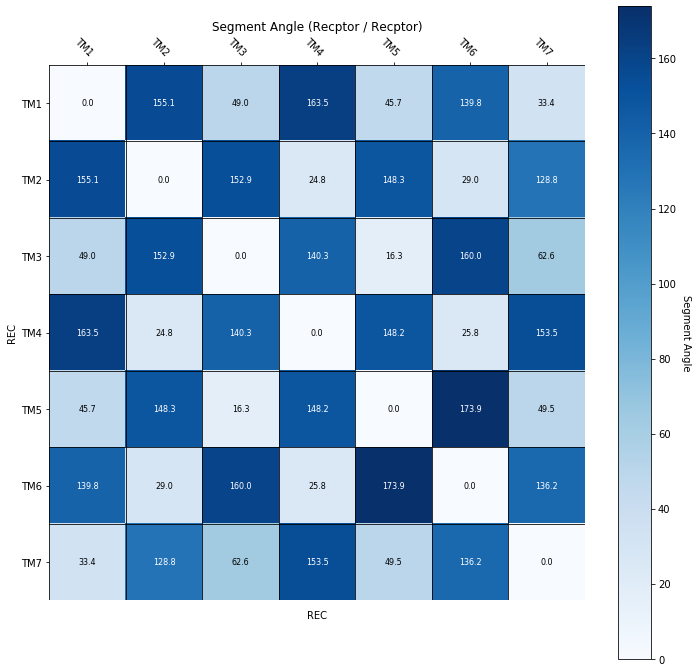

In [6]:
matrix=get_segments_angle(rec_segments,rec_chainid,rec_segments,rec_chainid)

xlabels=rec_labels
ylabels=rec_labels
x_axis_label="REC"
y_axis_label="REC"
title="Segment Angle (Recptor / Recptor)"

plt.figure(figsize=(12,12))
plot_index = 1
ax = plt.subplot(1, 1, plot_index)
im,cbar = heatmap(matrix,xlabels, ylabels,ax=ax,cmap="Blues", cbarlabel="Segment Angle")
texts = annotate_heatmap(im, valfmt="{x:.1f}", size=8)
ax.set_title(title)
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)


Text(0, 0.5, 'Ga')

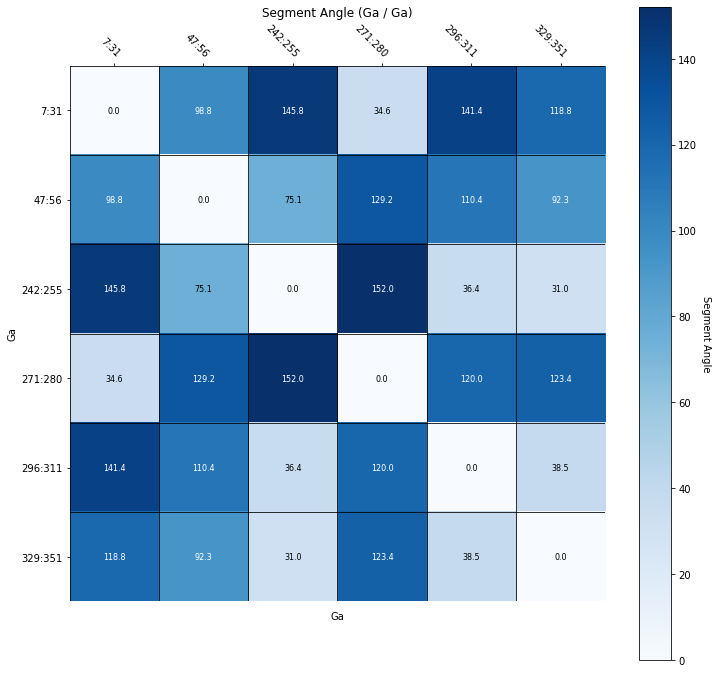

In [7]:
matrix=get_segments_angle(ga_segments,ga_chainid,ga_segments,ga_chainid)

xlabels=ga_segments
ylabels=ga_segments
x_axis_label="Ga"
y_axis_label="Ga"
title="Segment Angle (Ga / Ga)"

plt.figure(figsize=(12,12))
plot_index = 1
ax = plt.subplot(1, 1, plot_index)
im,cbar = heatmap(matrix,xlabels, ylabels,ax=ax,cmap="Blues", cbarlabel="Segment Angle")
texts = annotate_heatmap(im, valfmt="{x:.1f}", size=8)
ax.set_title(title)
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)


Text(0, 0.5, 'REC')

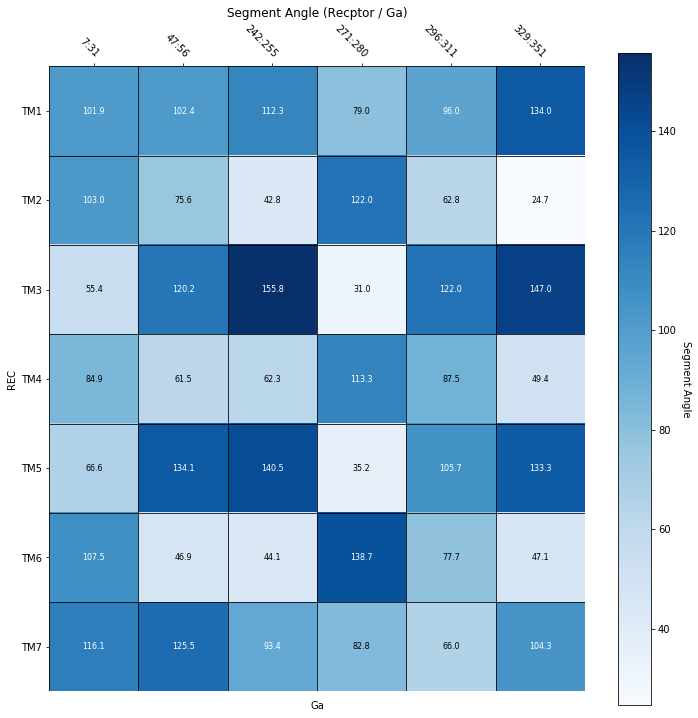

In [8]:
matrix=get_segments_angle(rec_segments,rec_chainid,ga_segments,ga_chainid)

xlabels=rec_labels
ylabels=ga_segments
x_axis_label="Ga"
y_axis_label="REC"
title="Segment Angle (Recptor / Ga)"

plt.figure(figsize=(12,12))
plot_index = 1
ax = plt.subplot(1, 1, plot_index)
im,cbar = heatmap(matrix,xlabels, ylabels,ax=ax,cmap="Blues", cbarlabel="Segment Angle")
texts = annotate_heatmap(im, valfmt="{x:.1f}", size=8)
ax.set_title(title)
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
